# Notes

**Focus on**:
- Quality of data
- Log your data and calls when using data scraping
- Creativity
- Visualization (explanatory figures), simple is better
- Be critical of your data collection and generating process
    - Bias
    - Missing data
        - Ignore
        - Collect new data
        - Remove or replace missing data
    - Internal and external validity
    - Data collection type (random, survey, big data, other)
- Less focus on the analytical section and more on the collection and presentation

### Reflect on the ethical aspect
- Do yourespectprivacy? 
- Can single individualsbeidentified? 
- What are the potential consequences?
- Are there ethical considerations?
    - With respect to individuals? 
    - With respectto firmsor organizations?
- Consider the GDPR:
    - Is it anonymous? 
    - Personal data or statistics?
    - Any change of re-identification?

### Project ideas

- Factor based investing (use google or yahoo finance API)
- Trump tweet correlation with stock market
- Don't use LinkedIn
- 


### Logging

- Log your calls, use it to determine success ratio
    - Where did the call fail? Rewrite code.
    - Don't be greedy. time.sleep(0.5) between each call.
- Visualize the log (lecture 10)

We start by importing our data source to Python. The file *tweets.json* is created from [the Trump twitter archive](http://www.trumptwitterarchive.com/archive). We have selected all tweets from the 20th of January 2017 (assumed office) to 21st of August 2019.

In [148]:
# Importing packages
import pandas as pd
import json, codecs
import scraping_class, time
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from IPython.display import display, HTML
% matplotlib inline


In [56]:
logfile = 'my_log'## name your log file.
connector = scraping_class.Connector(logfile)
data = []
# Fetching data
for i in range(2017,2020):
    url = 'http://www.trumptwitterarchive.com/data/realdonaldtrump/'+str(i)+'.json'
    r, call_id = connector.get(url, 'Tweets')
    json_file = r.json() 
    data += json_file[::-1] # invert list
    time.sleep(0.5) # set sleep timer to prevent unintentional DOS attacks


In [74]:
# Creating and manipulating dataframes
# Main dataframe
df = pd.DataFrame(data)
date = [i[2]+i[1]+i[-1]+'-'+i[3] for i in df['created_at'].str.split(' ')] # slice date
df['datetime'] = date
df['datetime'] = pd.to_datetime(df['datetime'], format='%d%b%Y-%H:%M:%S') # format datetime 
df = df[(df['datetime'] > '2017-01-20')] # filter by relevant date
df = df.reset_index(drop=True).sort_values(by=['datetime']) # set index to date
df = df.query("is_retweet == False") # drop retweets

#Trade war dataframe
df_trade = df[(df['datetime'] > '2018-03-02')] # filter by relevant date

# Keyword dataframe
keywords = ['tariff','trade war','trade']
#keywords = ['china', 'tariff','mexico','europe','billions','trade-war','war','xi jinping'] # list of relevant keywords
df['keyword'] = df['text'].str.contains('(?i)|'.join(keywords)) # search for keywords while ignoring word case (upper/lower)
df_filter = df.query("keyword == True") # filter query to remove retweets and non relevant tweets

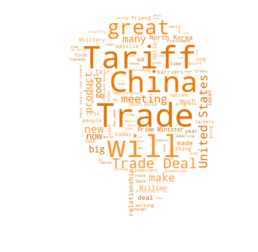

In [224]:
#WORDCLOUD

# function to get custom color for wordcloud
def custom_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 30 # int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(100, 160)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
 
# picture used as shape
trump_mask = np.array(Image.open("trump_mask.jpg").transpose(Image.FLIP_LEFT_RIGHT))

# wordcloud for df_filter
text = " ".join(tweet for tweet in df_filter['text'][df_filter['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png") # save file

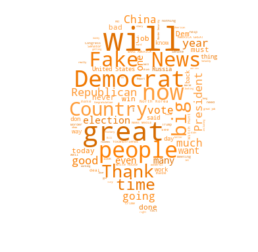

In [72]:
# wordcloud for df
text = " ".join(tweet for tweet in df['text'][df['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_all.png") # save file

In [159]:
# Define functions to display multiple tables
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )
# Fetching trade balance data
url = 'https://www.census.gov/foreign-trade/balance/c5700.html'
r, call_id = connector.get(url,'trade_balance') # connecting and saving connection to log file
dfs = pd.read_html(url) # read the tables
multi_table(dfs[0:4])  # display

,Month,Exports,Imports,Balance
0,January 2019,7134.3,41603.8,-34469.5
1,February 2019,8433.6,33194.4,-24760.8
2,March 2019,10426.5,31175.7,-20749.1
3,April 2019,7896.3,34798.9,-26902.6
4,May 2019,9074.5,39269.1,-30194.6
5,June 2019,9034.7,39002.3,-29967.6
6,TOTAL 2019,52000.0,219044.3,-167044.3
,Month,Exports,Imports,Balance
0,January 2018,9902.6,45765.6,-35863.1
1,February 2018,9759.9,39020.6,-29260.7


In [160]:
# display latex code
for i in range(4):
    print(dfs[i].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
         Month &  Exports &   Imports &   Balance \\
\midrule
  January 2019 &   7134.3 &   41603.8 &  -34469.5 \\
 February 2019 &   8433.6 &   33194.4 &  -24760.8 \\
    March 2019 &  10426.5 &   31175.7 &  -20749.1 \\
    April 2019 &   7896.3 &   34798.9 &  -26902.6 \\
      May 2019 &   9074.5 &   39269.1 &  -30194.6 \\
     June 2019 &   9034.7 &   39002.3 &  -29967.6 \\
    TOTAL 2019 &  52000.0 &  219044.3 & -167044.3 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
          Month &   Exports &   Imports &   Balance \\
\midrule
   January 2018 &    9902.6 &   45765.6 &  -35863.1 \\
  February 2018 &    9759.9 &   39020.6 &  -29260.7 \\
     March 2018 &   12652.1 &   38327.6 &  -25675.5 \\
     April 2018 &   10503.8 &   38303.9 &  -27800.1 \\
       May 2018 &   10428.2 &   43965.7 &  -33537.5 \\
      June 2018 &   10860.1 &   44612.1 &  -33752.0 \\
      July 2018 &   10134.6 &   47120.6 &  -36986.0 \\
    August 2018 &    9285.9 &

,Month,Exports,Imports,Balance
0,January 2016,8208.9,37126.4,-28917.5
1,February 2016,8080.5,36066.9,-27986.4
2,March 2016,8925.6,29812.3,-20886.8
3,April 2016,8679.7,32920.2,-24240.5
4,May 2016,8542.0,37513.7,-28971.8


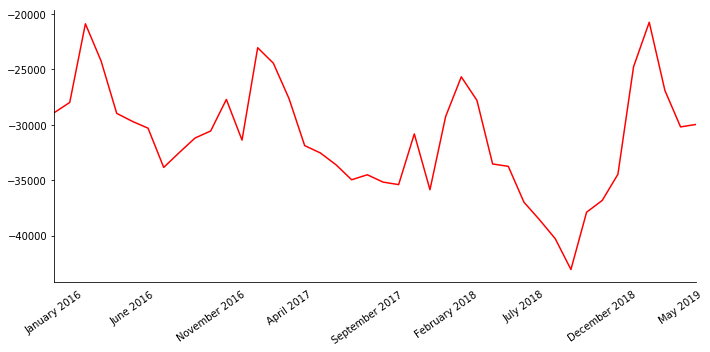

In [220]:
df_trade = pd.concat([dfs[i][:-1] for i in range(4)][::-1]) # removing "total" and concatenating data frames
display(df_trade.head())

# Plotting figure
ax = plt.gca()
df_trade.plot(kind='line',x='Month',y='Balance', color='red', ax=ax, figsize = (10,5), rot = 35, legend=False)
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('tradebalance.png')
plt.show()